#FICO Analytic Challenge Week 4


##Feature Generation Concepts

This week students will continue to learn about feature engineering as a key component of building predictive models for fraud analytics. We will learn to create variables that incorporate the historical activity of a given credit card account holder. Students will gain an appreciation of how a feature may be a good indicator of fraud or non-fraud activity based on how overlapping the respective distributions are. We briefly introduce the concept of correlation.   

In [12]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [13]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [15]:
#Upload pre-processed data
df1 = pd.read_csv("/content/drive/MyDrive/FICO Analytic Challenge/Data/train.csv")
df2 = pd.read_csv("/content/drive/MyDrive/FICO Analytic Challenge/Data/test_A.csv")


In [18]:

#Distinguish between train and test sets for future notebooks
df1['is_train'] = 1
df2['is_train'] = 0


In [17]:
#Combine dataframes to be processed together
df = pd.concat([df1,df2])

In [19]:
#It often helps to decompose the datetime into more useful fields
df['datetime'] =  pd.to_datetime(df['transactionDateTime'])
df['transactionHour'] = df['datetime'].dt.hour

#Since many of our features will be calculated at the account level, let's sort our features accordingly
df = df.sort_values(by=['pan', 'datetime'])

#When reordering data, it's customary to reset the index to align with the order of the rows
df.reset_index(drop=True, inplace=True)

# Handling Non-Numeric Values

- In transaction data, many features are categorical, such as the type of transaction (cash, online purchase, etc.), the country of the merchant, or the type of merchant itself. <font
color
='red'>Machine learning algorithms require numerical input</font>, so we need to convert these categorical features into numerical values. A common method to achieve this is Label Encoding.

- **Label Encoding** is useful when the categorical variable has only two possible values. It assigns 0 and 1 to the two categories. You have seen this, for example, in the binary variables we defined in week 3. Some examples of these are is_cnp and IS_0_TO_5AM

## Let's again take a look at what fields we have available to generate our features from

In [20]:
df.columns

Index(['pan', 'merchant', 'category', 'transactionAmount', 'first', 'last',
       'gender', 'street', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'mdlIsFraudTrx',
       'mdlIsFraudAcct', 'transactionDateTime', 'is_train', 'merchCountry',
       'merchState', 'cardholderCountry', 'cardholderState', 'datetime',
       'transactionHour'],
      dtype='object')

Using variables such as name, gender, or even city in a neural network model can lead to ethical violations primarily due to privacy concerns and potential biases. Personal identifiers like 'first' and 'last' names can compromise the anonymity of individuals, leading to privacy breaches. Variables like 'gender', 'city', 'state', and 'zip' can introduce biases, as they may be correlated with sensitive demographic information, potentially resulting in unfair or discriminatory outcomes. For instance, gender bias might lead to unequal treatment or opportunities based on sex. Geographical data such as 'street', 'city', 'state', and 'zip' codes can also perpetuate socio-economic biases and contribute to systemic inequalities. Additionally, using 'job' and 'dob' (date of birth) can further exacerbate age and employment discrimination. Therefore, it is crucial to carefully consider the ethical implications and ensure proper data anonymization and fairness in model training.

In [21]:
#Let's remove some of these variables to be consistent with our ethical obligations:
bad_vars = ['first', 'last', 'gender', 'street', 'zip', 'city_pop', 'job', 'dob']
df.drop(columns=bad_vars,inplace=True)

#Sometimes it's convenient to create an array of the base variables before we start defining features
base_cols = df.columns

## We can define some more binary features based on these which may or may not be indicative of fraud

merchant state and time

In [22]:
def compare_merchant_state_and_time(df):
    df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])


    df['last_merchant_state'] = df.groupby('pan')['merchState'].shift()
    df['last_transaction_time'] = df.groupby('pan')['transactionDateTime'].shift()

    # Create a binary feature for whether the merchant state has changed
    df['state_changed'] = (df['merchState'] != df['last_merchant_state']).astype(int)


    df['time_since_last_transaction'] = (df['transactionDateTime'] - df['last_transaction_time']).dt.total_seconds() / 3600

    return df

df = compare_merchant_state_and_time(df)



wednesday_purchase

In [23]:
def track_wednesday(df):

  df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])

  df['day_of_week'] = df['transactionDateTime'].dt.dayofweek

  df['wednesday_purchase'] = ((df['day_of_week'] == 3)).astype(int)

  return df


df1 = track_wednesday(df1)



In [24]:
def calculate_average_spending_per_category(df):

    avg_spending_per_category = df.groupby(['pan', 'category'])['transactionAmount'].mean().reset_index()
    avg_spending_per_category.rename(columns={'transactionAmount': 'average_spending'}, inplace=True)
    return avg_spending_per_category

# Calculate the average spending per category
avg_spending_per_category = calculate_average_spending_per_category(df)



In [25]:
#Calculate some basic binary variables

#Fraudsters want to get as much money as fast as possible. Having a high value variable might catch some of the more greedy criminals
df['IsHighValue'] = (df['transactionAmount'] > 100.).astype(int)

#Transactions occurring in a country different from the customer's home country can indicate potential fraud, especially if the customer rarely travels.
df['is_international'] = (df['merchCountry'] != df['cardholderCountry']).astype(int)

#Fraud is most easily committed anonymously and discreetly; by conducting the crime over the internet, the chances of being caught are much lower.
df['is_cnp'] =  (df['category'].apply(lambda x: x[-3:] == 'net')).astype(int)

df['is_shoppingnet'] = (df['category'].apply(lambda x: x == 'shopping_net')).astype(int)

df['is_grocery_net'] =  (df['category'].apply(lambda x: x == 'grocery_net')).astype(int)

df['is_travel'] = (df['category'] == 'travel') & (df['transactionAmount'] > 400).astype(int)

#Similarly, security and awareness are at their lowest at off hours. Fraudsters frequently exploit this weakness.
df['IS_0_TO_5AM'] = (df['transactionHour'].astype(int) < 5).astype(int)

df['average_spending'] = df.groupby('pan')['transactionAmount'].transform('mean') # This line is added to calculate and create the 'average_spending' column

df['wednesday_buy'] = ((df1['day_of_week'] == 3)).astype(int)

df['monday_buy']   = ((df1['day_of_week'] == 0)).astype(int)

df['spending_below_avg_20'] = (df['average_spending'] - df['transactionAmount'] >= 20).astype(int)

df['spending_above_threshold'] = (df['transactionAmount'] > df['average_spending'] + 15).astype(int)

df['outside_state_purchase'] = (df['merchState'] != df['cardholderState']).astype(int)


In [26]:
#Check to see if these features have been properly added to our dataframe
df.columns

Index(['pan', 'merchant', 'category', 'transactionAmount', 'lat', 'long',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'mdlIsFraudTrx',
       'mdlIsFraudAcct', 'transactionDateTime', 'is_train', 'merchCountry',
       'merchState', 'cardholderCountry', 'cardholderState', 'datetime',
       'transactionHour', 'last_merchant_state', 'last_transaction_time',
       'state_changed', 'time_since_last_transaction', 'IsHighValue',
       'is_international', 'is_cnp', 'is_shoppingnet', 'is_grocery_net',
       'is_travel', 'IS_0_TO_5AM', 'average_spending', 'wednesday_buy',
       'monday_buy', 'spending_below_avg_20', 'spending_above_threshold',
       'outside_state_purchase'],
      dtype='object')

In [27]:
# prompt: drop average spending column

# Drop the 'average_spending' column
df = df.drop(columns=['last_transaction_time','last_merchant_state','state_changed'])

In [28]:
#Define an array of our features so far
binary_vars = ['IsHighValue','is_international', 'is_cnp', 'IS_0_TO_5AM', 'wednesday_buy','spending_below_avg_20','spending_above_threshold']#,'outside_state_purchase']



The same thing can be accomplished by observing that our new features are simply the set of the new dataframe's variables without the base data's columns


In [29]:
binary_vars = list(set(df.columns) - set(base_cols))

## Check the fraud rate for each of these variables for 0 and 1 values

In [30]:
#We can loop over our features and compare the fraud rate for when each of these conditions are met
for var in binary_vars:
    is_condition = df[df[var] == 1]['mdlIsFraudAcct'].value_counts(normalize=True)
    not_condition = df[df[var] == 0]['mdlIsFraudAcct'].value_counts(normalize=True)
    print(f'{var} has proportionally',(is_condition[1]/not_condition[1]-1)*100, '% more fraud')


is_grocery_net has proportionally 0.8054255531297017 % more fraud
time_since_last_transaction has proportionally 436.01766904519195 % more fraud
IS_0_TO_5AM has proportionally 34.52471489656017 % more fraud
spending_below_avg_20 has proportionally 3.9993198411219844 % more fraud
wednesday_buy has proportionally -1.8301912227129735 % more fraud
is_shoppingnet has proportionally 1.1610898317769403 % more fraud
monday_buy has proportionally 0.5465998933773974 % more fraud


KeyError: 1

In [35]:
#Let's try and be more in-line with the data as was seen in week 3:
df['is_late_night'] = ((df['transactionHour'].astype(int) < 4) | (df['transactionHour'].astype(int) > 21)).astype(int)

In [36]:
binary_vars = ['IsHighValue','is_international', 'is_cnp', 'IS_0_TO_5AM','wednesday_buy','spending_below_avg_20','is_late_night','monday_buy','spending_above_threshold','is_shoppingnet','is_travel','is_grocery_net']

In [37]:
#We can again loop over our features and compare the fraud rate for when each of these conditions are met
for var in binary_vars:
    is_condition = df[df[var] == 1]['mdlIsFraudAcct'].value_counts(normalize=True)
    not_condition = df[df[var] == 0]['mdlIsFraudAcct'].value_counts(normalize=True)
    print(f'{var} has proportionally',(is_condition[1]/not_condition[1]-1)*100, '% more fraud')


IsHighValue has proportionally -8.104025662025293 % more fraud
is_international has proportionally 66.21074775853376 % more fraud
is_cnp has proportionally 0.9734923731727019 % more fraud
IS_0_TO_5AM has proportionally 34.52471489656017 % more fraud
wednesday_buy has proportionally -1.8301912227129735 % more fraud
spending_below_avg_20 has proportionally 3.9993198411219844 % more fraud
is_late_night has proportionally 39.21607963158817 % more fraud
monday_buy has proportionally 0.5465998933773974 % more fraud
spending_above_threshold has proportionally -6.894380513973242 % more fraud
is_shoppingnet has proportionally 1.1610898317769403 % more fraud
is_travel has proportionally 10.519066645188758 % more fraud
is_grocery_net has proportionally 0.8054255531297017 % more fraud


### From this, we can see that all of these besides is_cnp might be good variables to use in our feature selections! We also may note that IS_0_TO_5AM and is_late_night variables both perform well, but since they contain very similar information, their correlation may lead to overemphasis on this information. We will talk about the pitfalls of correlated variables in week 5.

## Going beyond Label Encoding, we can start defining customer-specific features

###An important consideration for feature engineering is causality. I.e. we must restrict ourselves to only the past and present when calculating a feature for the current transaction. For instance, instead of taking the mean of our entire dataset, we are only allowed to take the mean of all transactions occurring prior to our current transaction. This is achieved using either the `expanding` or `rolling` functions.

In [38]:
# PAN behavior anomalies
#For this next line: the combination of expanding() and shift() take only the data prior to our current transaction
df['user_avg_amount'] = df.groupby('pan')['transactionAmount'].expanding().mean().shift().reset_index(level=0, drop=True)

##Let's break this down piece-by-piece
**df.groupby('pan'):** Groups the DataFrame by the 'pan' column. Each unique pan will form a separate group.

**['transactionAmount']**:
Selects the 'transactionAmount' column within each group for further operations.

**.expanding()**: Creates an expanding window, starting from the first transaction and expanding to include all transactions up to the current one for each pan.

**.mean()**: Calculates the mean of all transactions seen so far within the expanding window for each group.

**.shift()**: Shifts the result by one row for each customer, meaning the current row will have the mean of all prior transactions (not including the current one).

**.reset_index(level=0, drop=True)** Resets the index after the groupby operation, removing the 'pan' as an index and flattening the DataFrame. 'drop=True' ensures the 'pan' is not added back as a column.

In [39]:
#By comparing a user's current transaction to their normal spending activity, we may detect user-specific anomalies
df['RelativeAmount'] = df['transactionAmount'] / df['user_avg_amount']

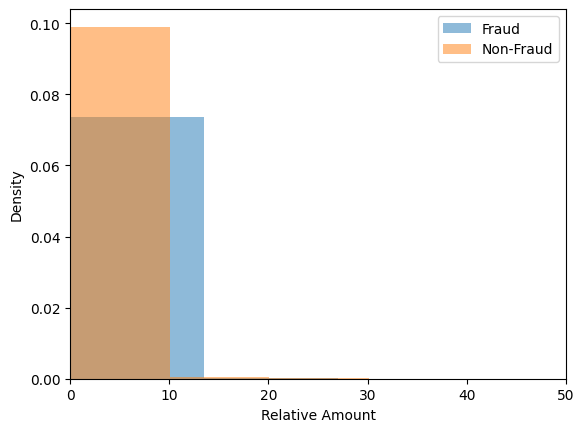

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Plot histograms
plt.hist(df[(df['mdlIsFraudAcct'] == 1) & (df['RelativeAmount'] > 0.)]['RelativeAmount'], bins=50, density=True, alpha=0.5, label='Fraud')
plt.hist(df[(df['mdlIsFraudAcct'] == 0) & (df['RelativeAmount'] > 0.)]['RelativeAmount'], bins=50, density=True, alpha=0.5, label='Non-Fraud')

# Add labels and legend
plt.xlabel('Relative Amount')
plt.ylabel('Density')
plt.xlim([0,50])
#plt.title('Normalized Histograms')
plt.legend()

# Show plot
plt.show()


## From this plot, it seems the two distributions are somewhat overlapping, but there is a sharp drop after RelativeAmount > 10. This might make a good binary variable. Think about how you might implement this into your model. For now, let's explore other options.

# Generating New Variables

- Creating new features from existing data can help uncover patterns and improve the performance of machine learning models. Read more on the process of feature engineering in the following links: https://builtin.com/articles/feature-engineering up to "Best Feature Engineering Tools to Know section." https://www.featureform.com/post/feature-engineering-guide up to "The Lifecycle of a Machine Learning Project section." Here, we will generate new features that provide additional insights into the transaction behavior:



# Let's pause to reflect on our initial fields and the new features we've created

In [41]:
df.keys()

Index(['pan', 'merchant', 'category', 'transactionAmount', 'lat', 'long',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'mdlIsFraudTrx',
       'mdlIsFraudAcct', 'transactionDateTime', 'is_train', 'merchCountry',
       'merchState', 'cardholderCountry', 'cardholderState', 'datetime',
       'transactionHour', 'time_since_last_transaction', 'IsHighValue',
       'is_international', 'is_cnp', 'is_shoppingnet', 'is_grocery_net',
       'is_travel', 'IS_0_TO_5AM', 'average_spending', 'wednesday_buy',
       'monday_buy', 'spending_below_avg_20', 'spending_above_threshold',
       'outside_state_purchase', 'is_late_night', 'user_avg_amount',
       'RelativeAmount'],
      dtype='object')

Though we are limited with our available fields, there are still ways to squeeze useful features from an ostensibly incomplete dataset. Sometimes signal can be lost in the noise of non-fraud fluctuations. A good way to suppress this noise is by implementing a rolling windows average. In the example below, we see a very noise curve (blue), but with a rolling average, we can more easily ascertain the true nature of the pattern: a simple sin curve (red).
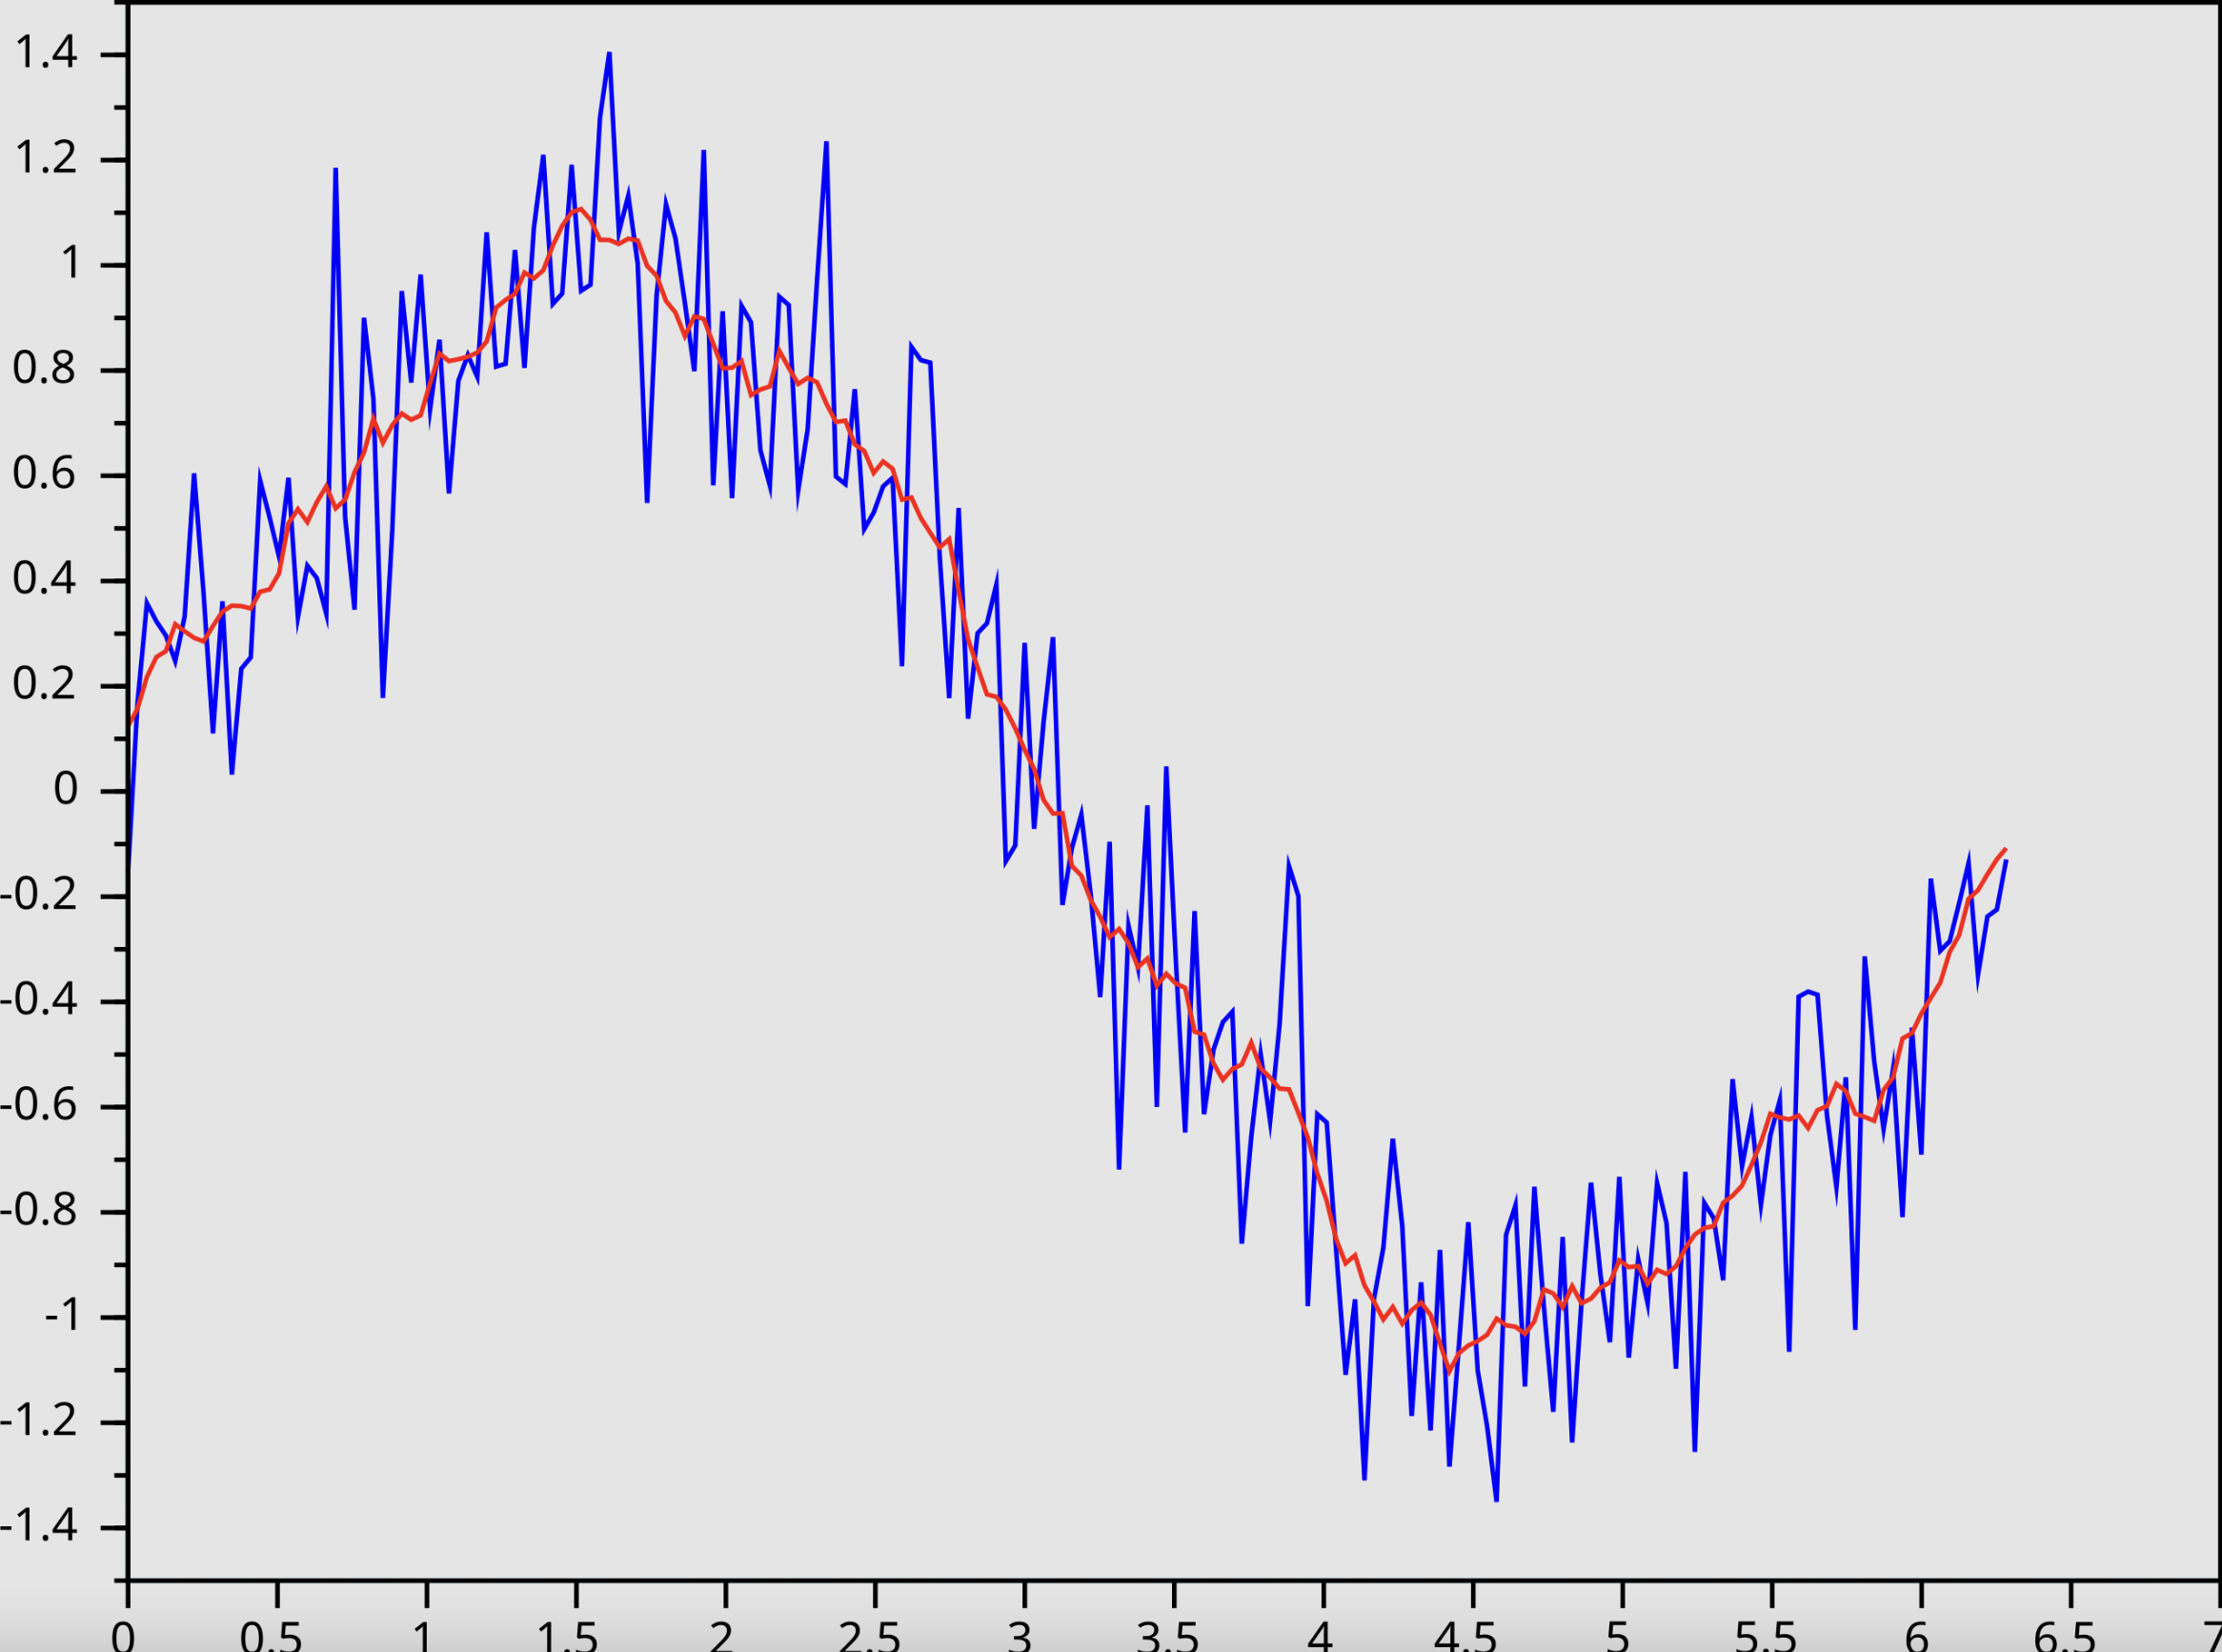

In [42]:
#Very short intervals between transactions can be suspicious, especially if they are unusual for the customer.
df['deltaTime'] = df.groupby('pan')['datetime'].transform(lambda x: x.diff().dt.total_seconds()) #Time in seconds between the current and last transactions

#df['deltaTime_merchstate'] = df.groupby(['pan','merchant','merchState'])['datetime'].transform(lambda x: x.diff().dt.total_seconds())

#This rolling average helps to understand the trend in transaction amounts. Sudden changes in trend might be indicative of fraud.
df['amt_trend_5e'] = df.groupby('pan')['transactionAmount'].transform(lambda x: x.rolling(window=5).mean())

#Instead of taking the trend over a number of events, we can also specify a period over which we're interested
df.set_index('datetime', inplace=True)

#Looking at the average of the last day's transactions may reveal a large average transaction trend
df['amt_trend_24h'] = df.groupby('pan')['transactionAmount'].transform(lambda x: x.rolling(window='24h').mean())

# Looking at the number volume of transactions can often also be an indicator of
# fraud. The perpetrators want to commit as muhc fraud as fast as possible
df['count_trend_1h'] = df.groupby('pan')['transactionAmount'].transform(lambda x: x.rolling(window='1h').count())

df['category_ratio'] = df.groupby('pan')['category'].transform(lambda x: (x == 'online').sum() / len(x))


df = df.fillna(0)
df.reset_index(inplace=True)
df['datetime'] =  pd.to_datetime(df['transactionDateTime'])

#Often times, fraudsters will purchase or withdraw the same item or amount in succession
df['repeat_amt'] = (df['transactionAmount'] == df.groupby('pan')['transactionAmount'].shift(1)).astype(int)


In [43]:
df.head()

datetime                pan                    merchant  \
0 2020-01-01 17:12:25  0033864050176488B  Stehr, Jewess and Schimmel   
1 2020-01-01 17:47:30  0033864050176488B            Fritsch and Sons   
2 2020-01-01 17:59:01  0033864050176488B   Tromp, Kerluke and Glover   
3 2020-01-01 18:05:38  0033864050176488B                Homenick LLC   
4 2020-01-01 18:08:36  0033864050176488B                Mayert Group   

         category  transactionAmount      lat     long  \
0        misc_net              35.83  41.1826 -92.3097   
1  health_fitness               1.89  41.1826 -92.3097   
2     grocery_net              18.53  41.1826 -92.3097   
3   personal_care              90.24  41.1826 -92.3097   
4    shopping_pos             156.86  41.1826 -92.3097   

                          trans_num   unix_time  merch_lat  ...  \
0  362febb0060ce2d6a995a72a116e34f4  1350565945  40.289849  ...   
1  de7d5f0356d41470cd02e719e2e0b196  1350568050  40.699982  ...   
2  c9d194a3266cd20b23478dd8d2361ef9  1350529141  40.295853  ...   
3  e860a23fcbb2d46956a6f4f7b18cfe3f  1353168338  40.535509  ...   
4  d3db2da4a5c741058ff57f61023e5353  1353168516  41.245006  ...   

   outside_state_purchase  is_late_night  user_avg_amount RelativeAmount  \
0                       1              0           0.0000       0.000000   
1                       0              0          35.8300       0.052749   
2                       1              0          18.8600       0.982503   
3                       1              0          18.7500       4.812800   
4                       0              0          36.6225       4.283159   

   deltaTime amt_trend_5e amt_trend_24h count_trend_1h category_ratio  \
0        0.0         0.00       35.8300            1.0            0.0   
1     2105.0         0.00       18.8600            2.0            0.0   
2      691.0         0.00       18.7500            3.0            0.0   
3      397.0         0.00       36.6225            4.0            0.0   
4      178.0        60.67       60.6700            5.0            0.0   

   repeat_amt  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 43 columns]

The t-statistic (or t-stat) is a value derived from a statistical hypothesis test. It is used to determine if there is a significant difference between the means of two groups, or to test other statistical hypotheses about the parameters of a population. The t-statistic is calculated using the sample data and compares the sample mean to the population mean, adjusted for the sample size and variability.



Feature: is_grocery_net, t-statistic: -5.022699354974616, p-value: 5.18629548198158e-07


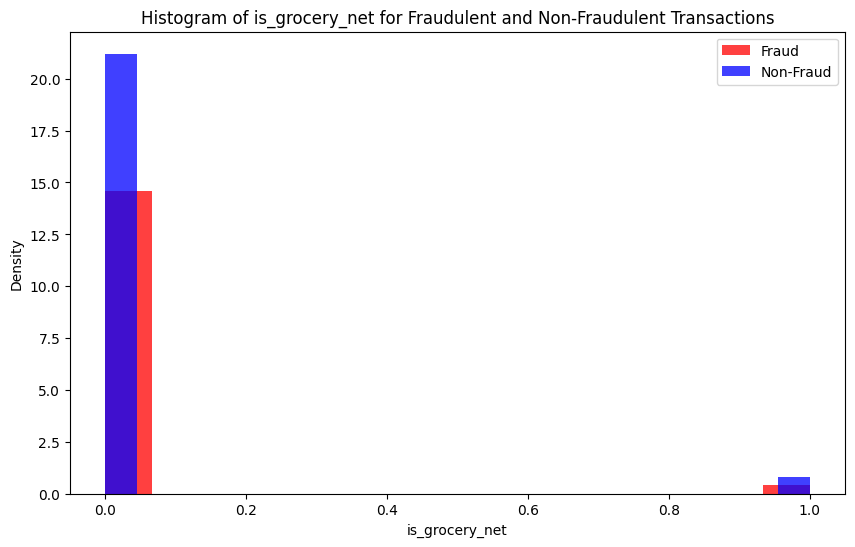

Feature: is_shoppingnet, t-statistic: 33.415502695778954, p-value: 1.2646087211601422e-231


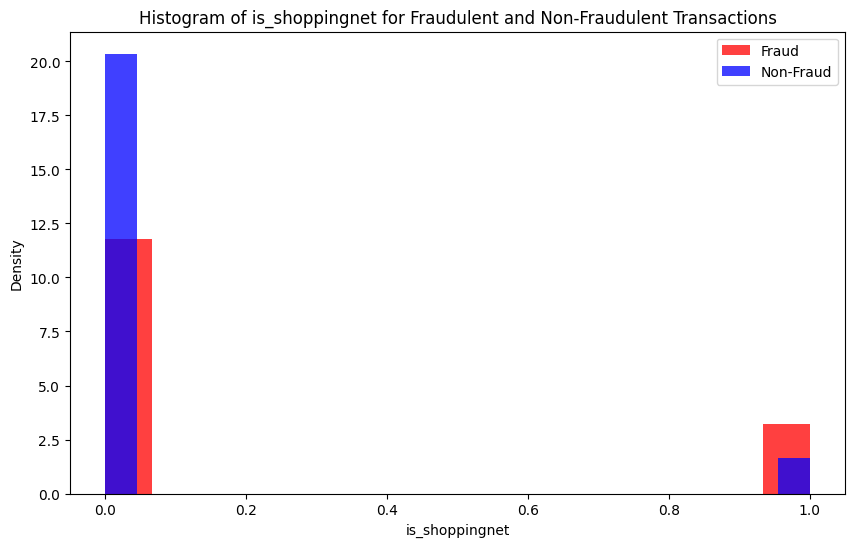

Feature: amt_trend_24h, t-statistic: 131.03815211998307, p-value: 0.0


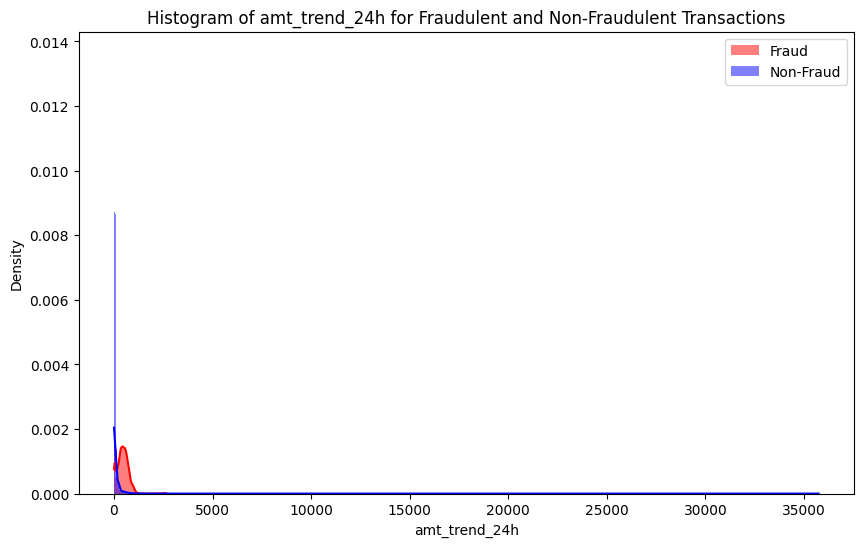

Feature: user_avg_amount, t-statistic: 25.028122102184437, p-value: 6.086547454906437e-134


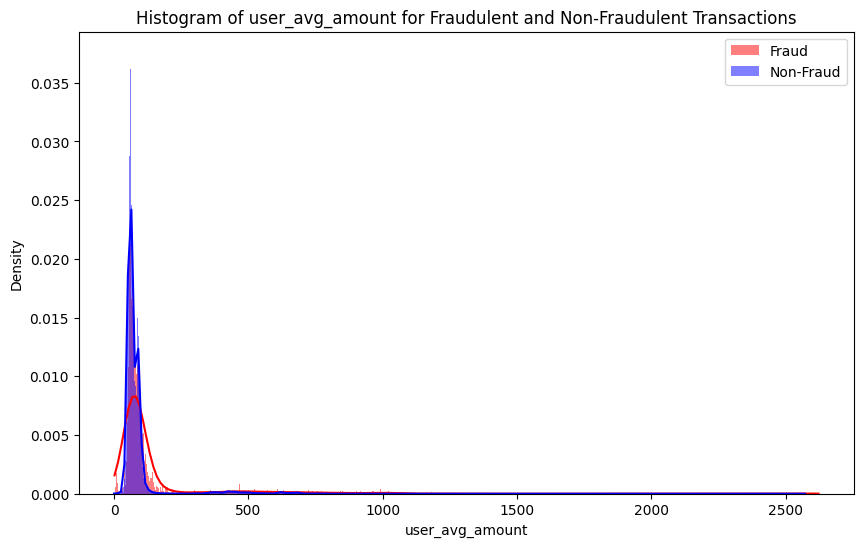

Feature: IsHighValue, t-statistic: 122.11560840404002, p-value: 0.0


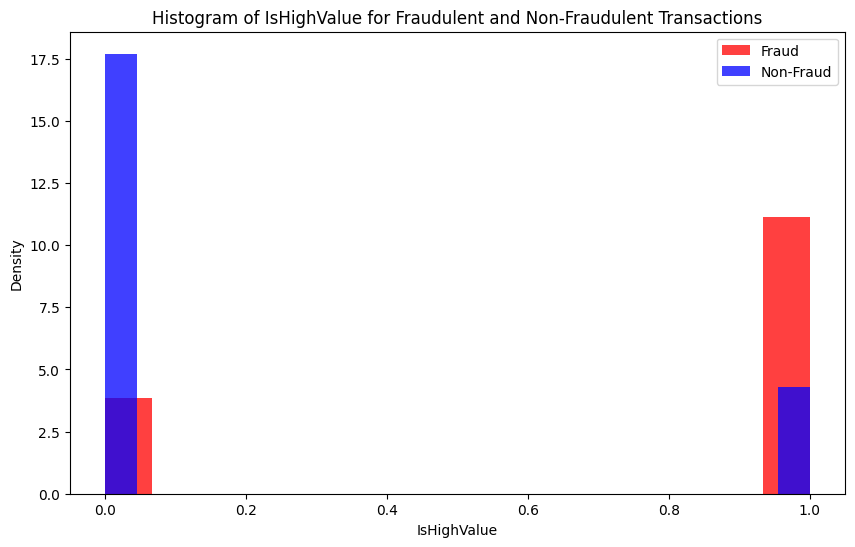

Feature: IS_0_TO_5AM, t-statistic: 86.5776979440063, p-value: 0.0


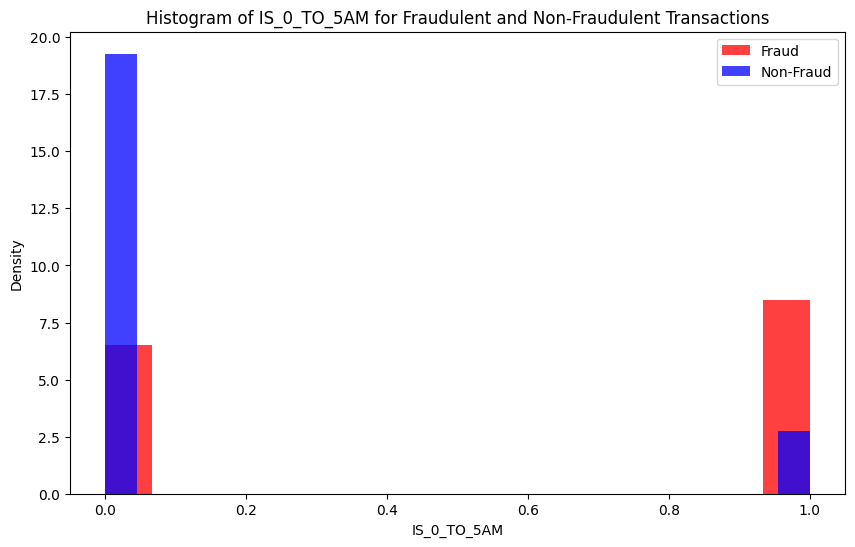

Feature: spending_below_avg_20, t-statistic: -61.990162046268466, p-value: 0.0


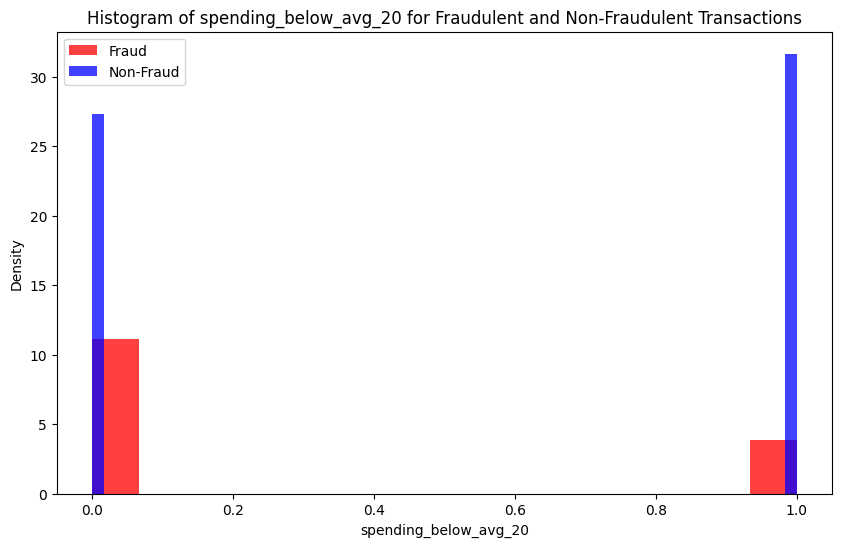

Feature: RelativeAmount, t-statistic: 78.50415062661267, p-value: 0.0


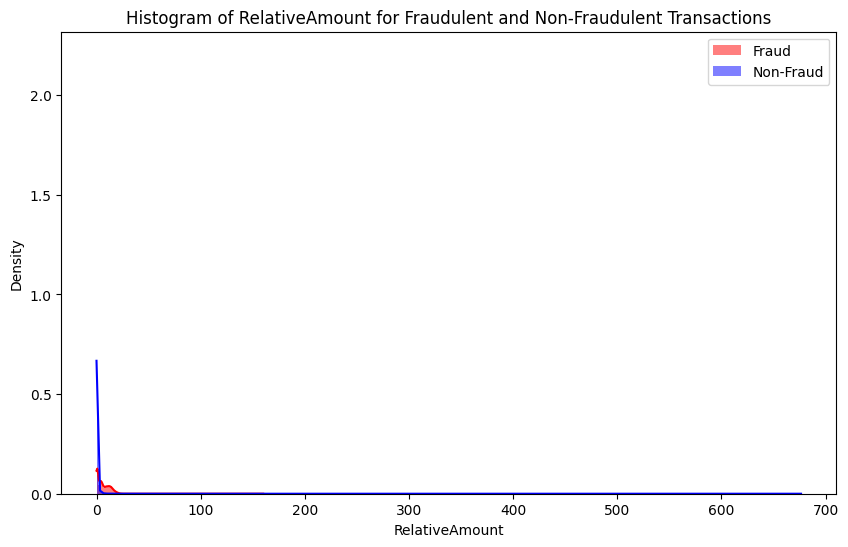

Feature: deltaTime, t-statistic: -38.72424143688431, p-value: 3.7475665333204207e-305


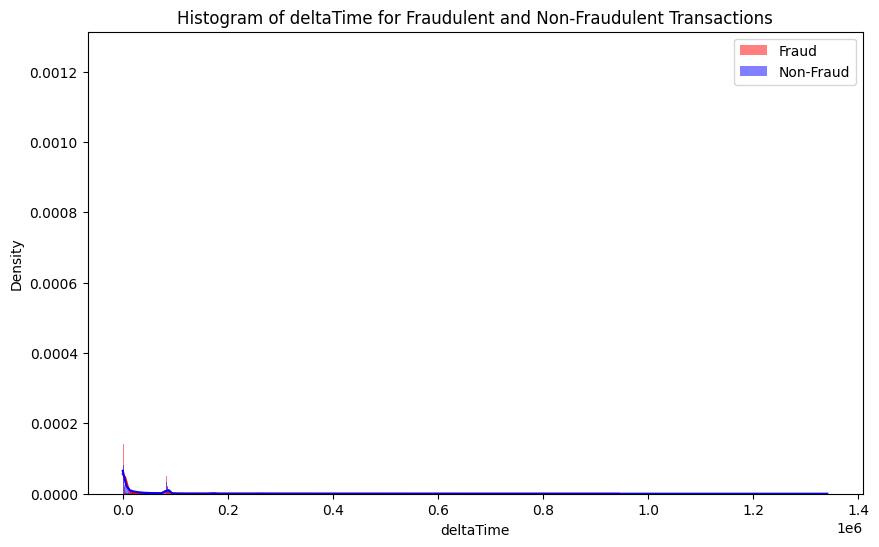

Feature: is_international, t-statistic: 9.317166012135834, p-value: 1.45952200864168e-20


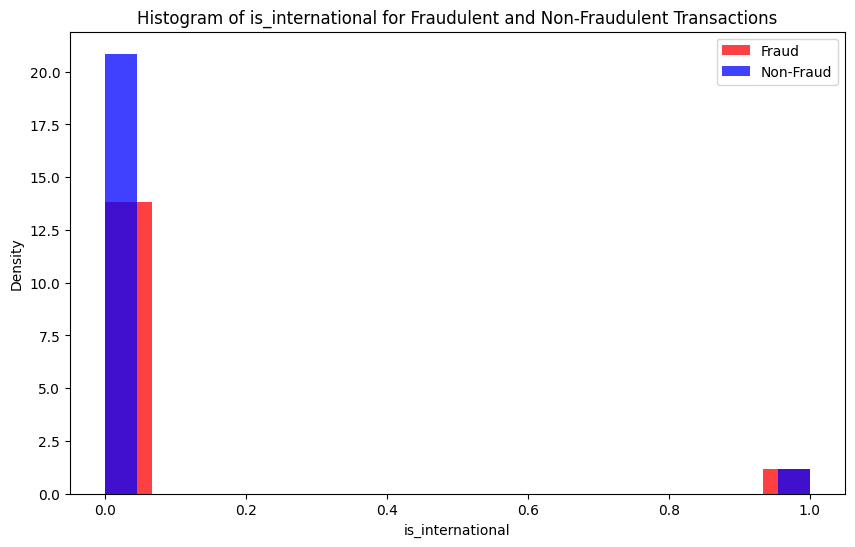

Feature: repeat_amt, t-statistic: 29.258432654147093, p-value: 2.9451095664021287e-180


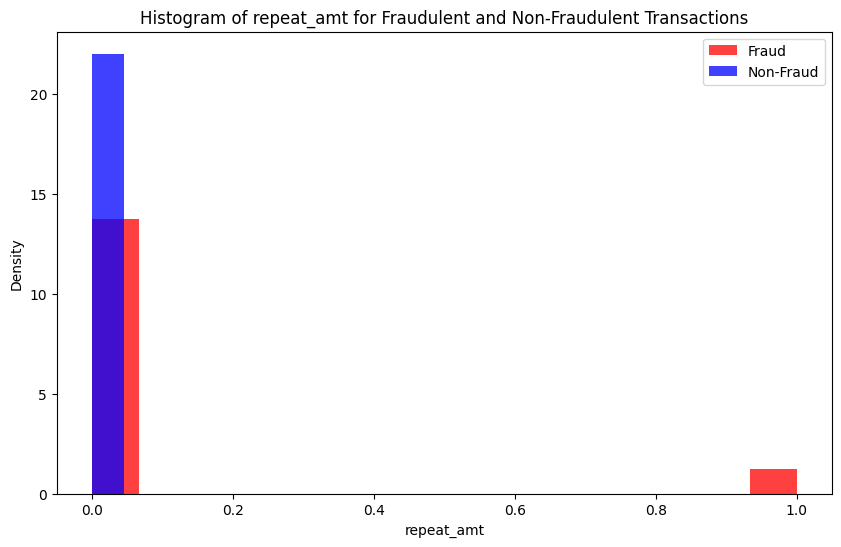

Feature: amt_trend_5e, t-statistic: 115.7527890531099, p-value: 0.0


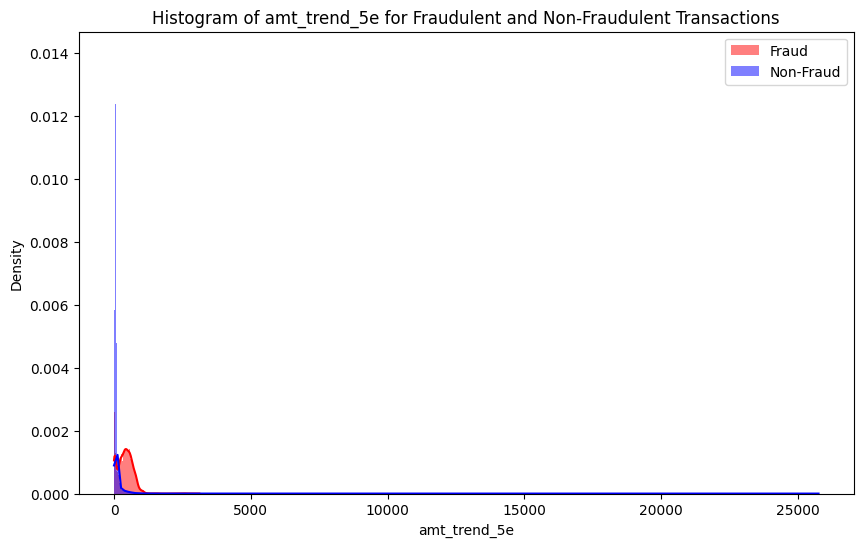

Feature: time_since_last_transaction, t-statistic: -38.724241436884334, p-value: 3.7475665333178633e-305


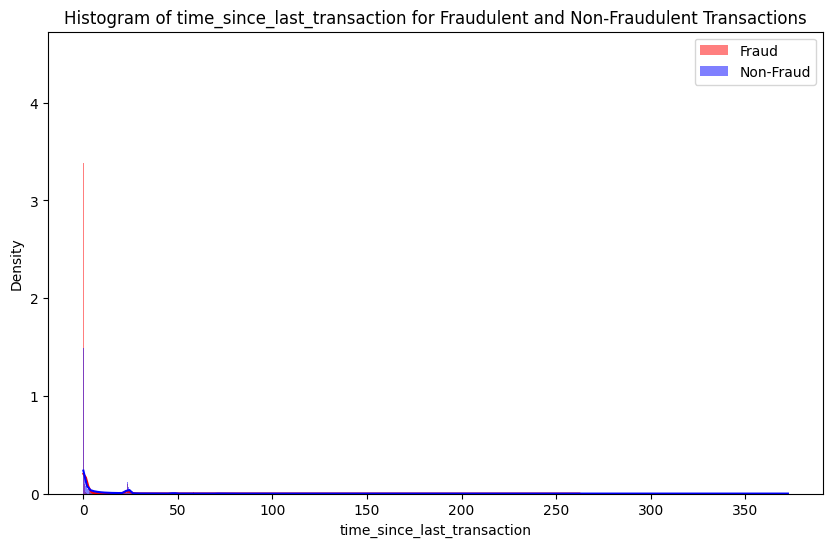

Feature: wednesday_buy, t-statistic: -0.8588187238809049, p-value: 0.39046194683571245


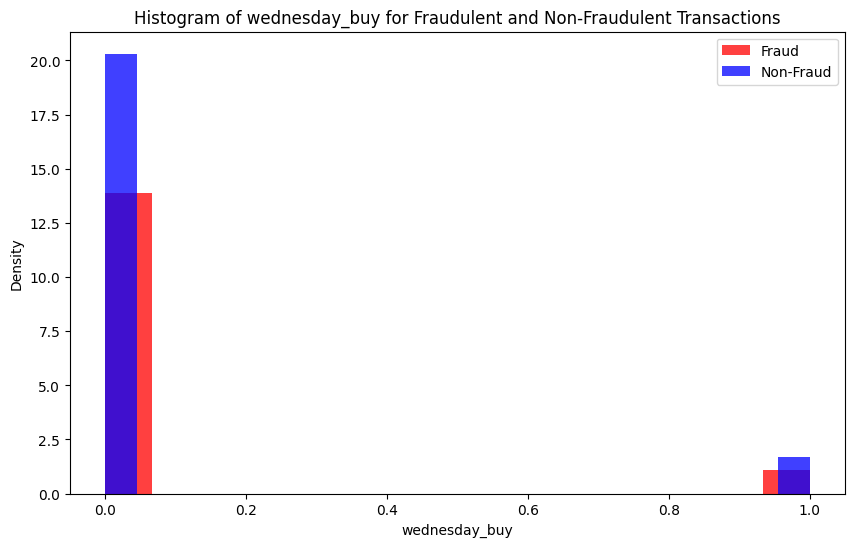

Feature: spending_above_threshold, t-statistic: 98.90461344022181, p-value: 0.0


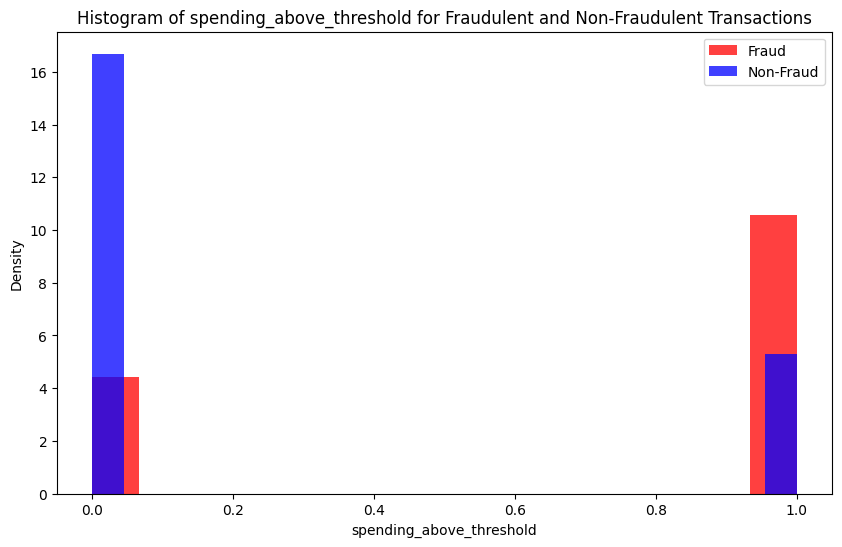

Feature: count_trend_1h, t-statistic: 45.16118534581668, p-value: 0.0


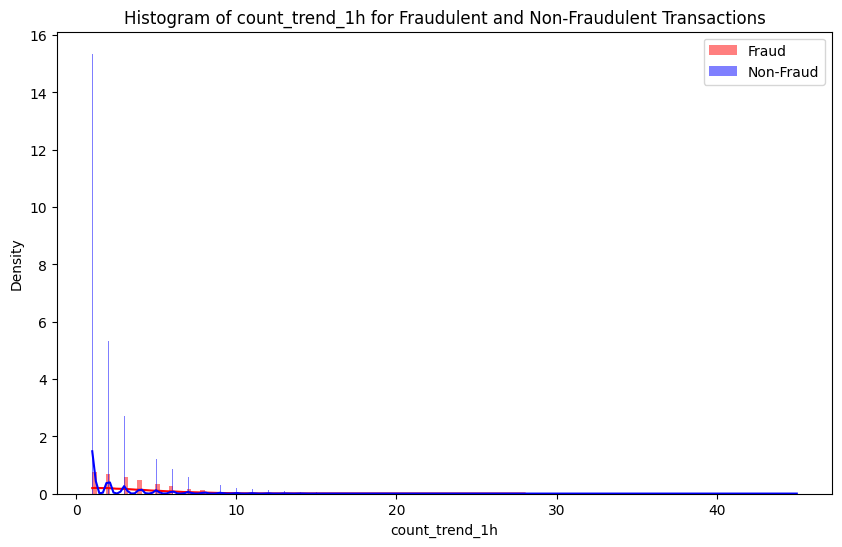

Feature: outside_state_purchase, t-statistic: 2.2333829917999415, p-value: 0.025546628868369243


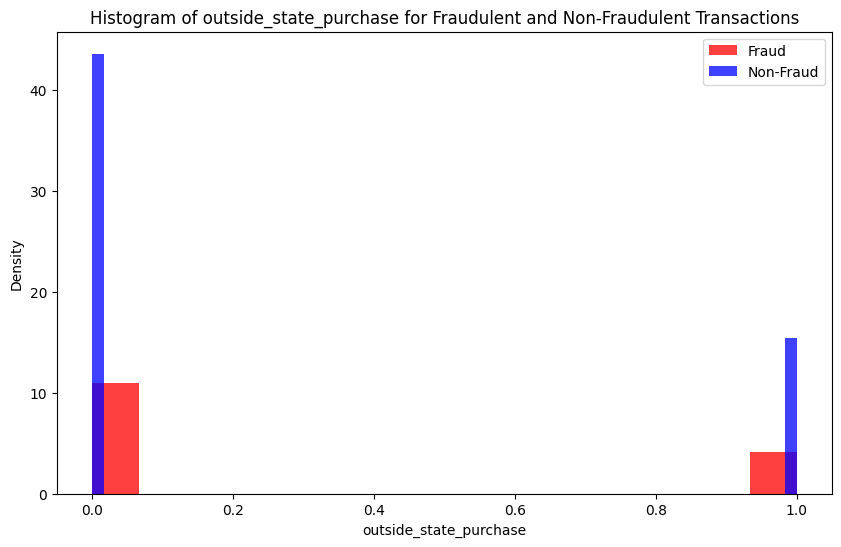

Feature: is_cnp, t-statistic: 40.31188170149835, p-value: 0.0


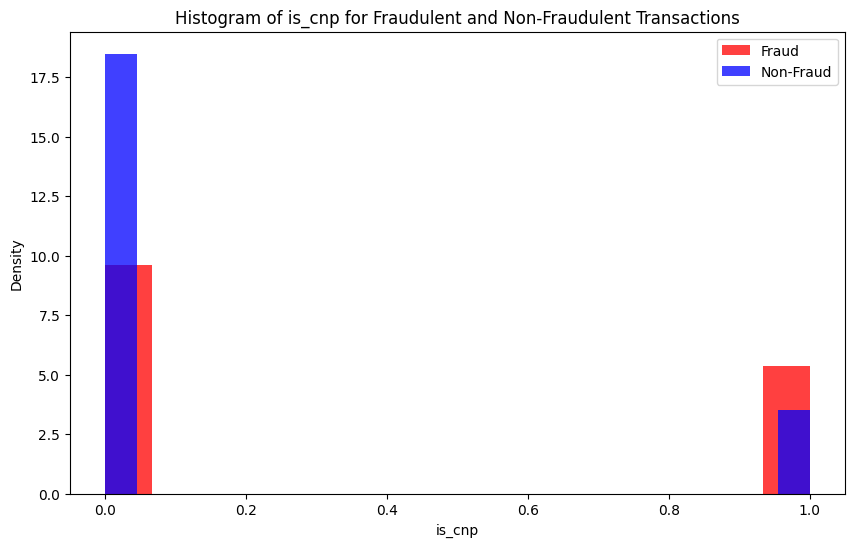

Feature: is_travel, t-statistic: 0.8845079446097858, p-value: 0.3764442386011613


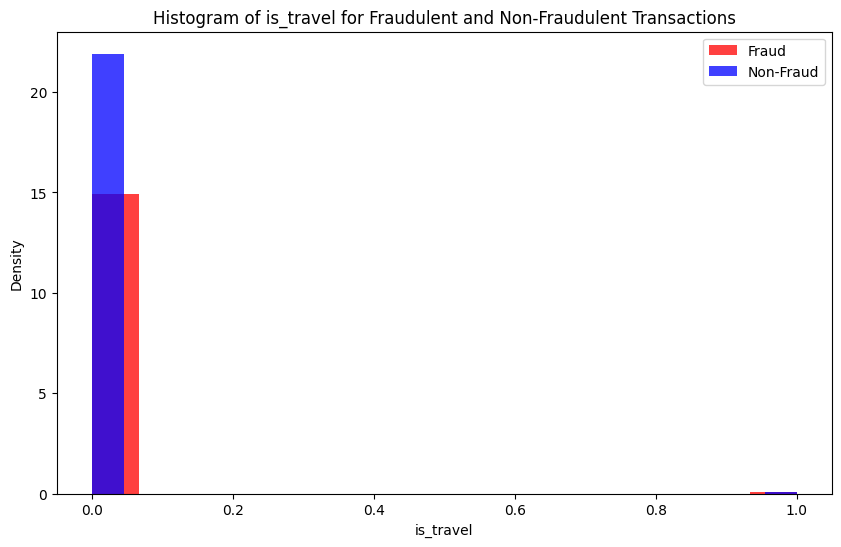

Feature: monday_buy, t-statistic: 1.0936500165504925, p-value: 0.27413592241962426


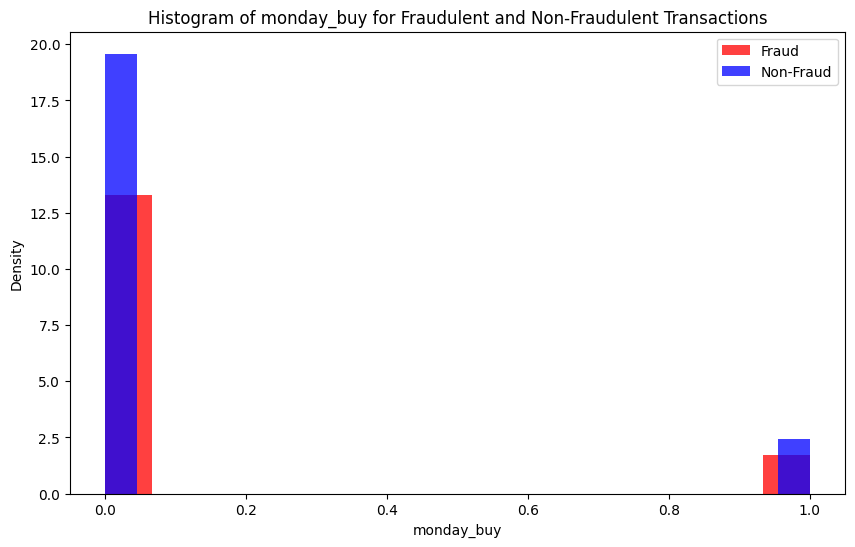

Feature: average_spending, t-statistic: 22.559772184310674, p-value: 7.902179736178846e-110


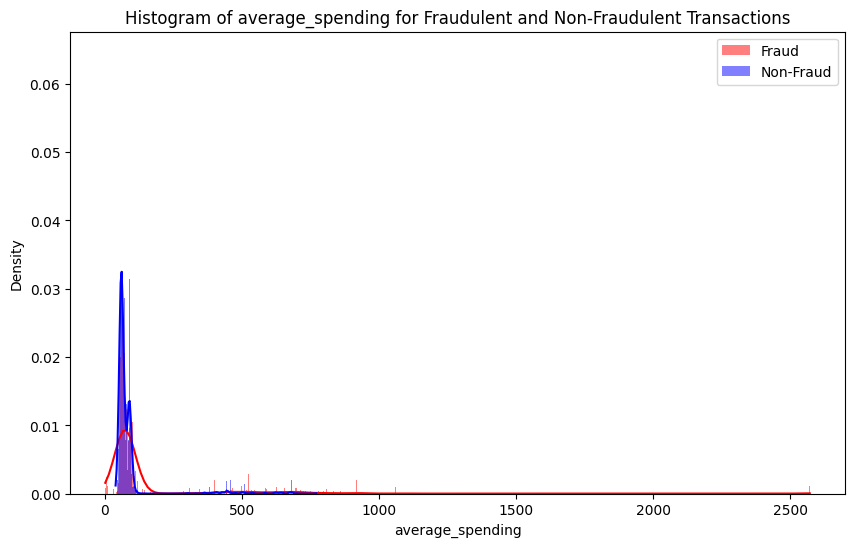

Feature: category_ratio, t-statistic: nan, p-value: nan


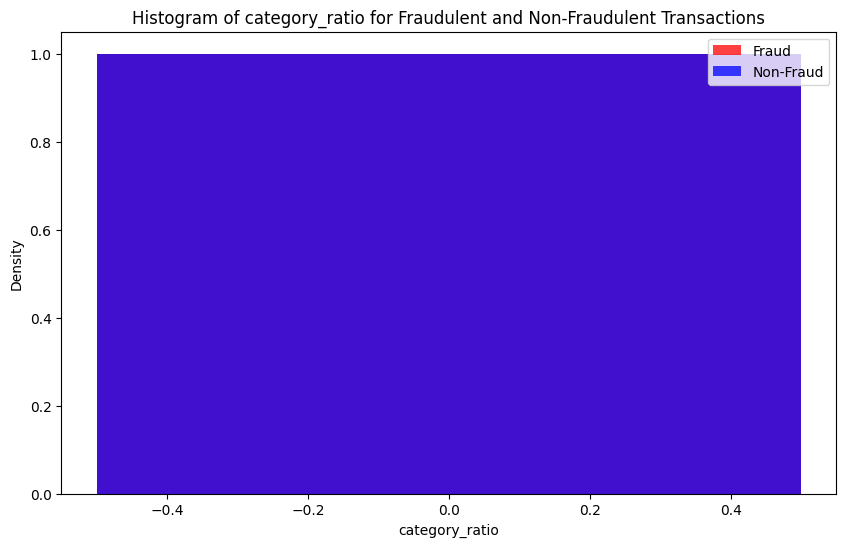

Feature: is_late_night, t-statistic: 95.21771018301571, p-value: 0.0


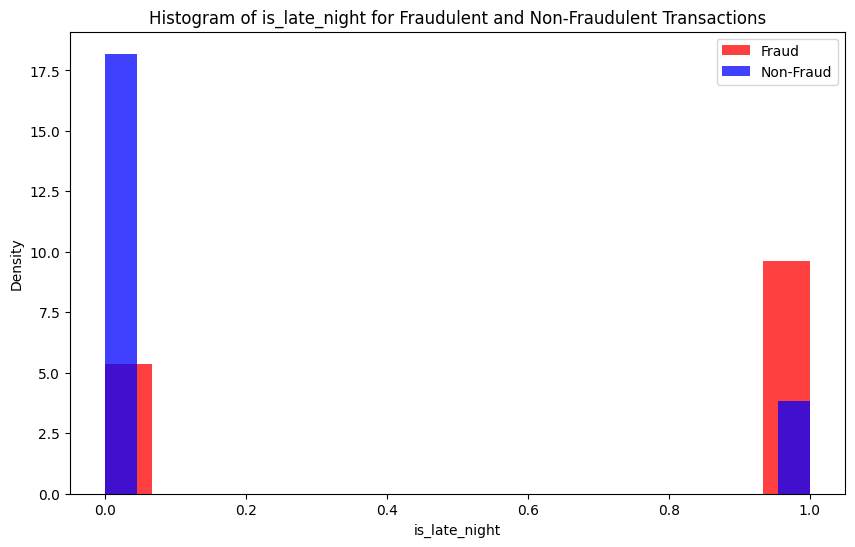

In [44]:
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# Generate descriptive statistics for fraud and non-fraud transactions
fraud = df[df['mdlIsFraudTrx'] == 1]
non_fraud = df[df['mdlIsFraudTrx'] == 0]

# Statistical tests and visualizations
features = list(set(df.columns) - set(base_cols))

for feature in features:
    # T-test
    t_stat, p_val = ttest_ind(fraud[feature].dropna(), non_fraud[feature].dropna(), equal_var=False)
    print(f'Feature: {feature}, t-statistic: {t_stat}, p-value: {p_val}')

    # Histogram
    if len(df[feature].unique()) > 2:
      kde = True
    else:
      kde = False
    plt.figure(figsize=(10, 6))
    sns.histplot(fraud[feature], color='red', label='Fraud', kde=kde, stat="density", linewidth=0)
    sns.histplot(non_fraud[feature], color='blue', label='Non-Fraud', kde=kde, stat="density", linewidth=0)
    plt.title(f'Histogram of {feature} for Fraudulent and Non-Fraudulent Transactions')
    plt.legend()
    plt.show()


# In addition to the time-based average and event-based average, we can create features such as:
- **Transaction Amount Difference:** Difference between the current and previous transaction amounts.
- **Transaction Frequency:** Number of transactions within a specific period.
- **Transaction Ratio:** Ratio of a specific type of transaction (e.g., online) to the total number of transactions.

- Try defining the above definitions and attaching columns to your dataframe in a similar way to the functions above

###Sometimes when we have a surplus of variables, or don't want the model to run for extended periods of time, we will curate our variable list to something more manageable given our resources. Later, we will use performance metrics and sensitivity to understand which variables are the best, but for now, we can look at which variables are highly correlated and may be redundant with each other

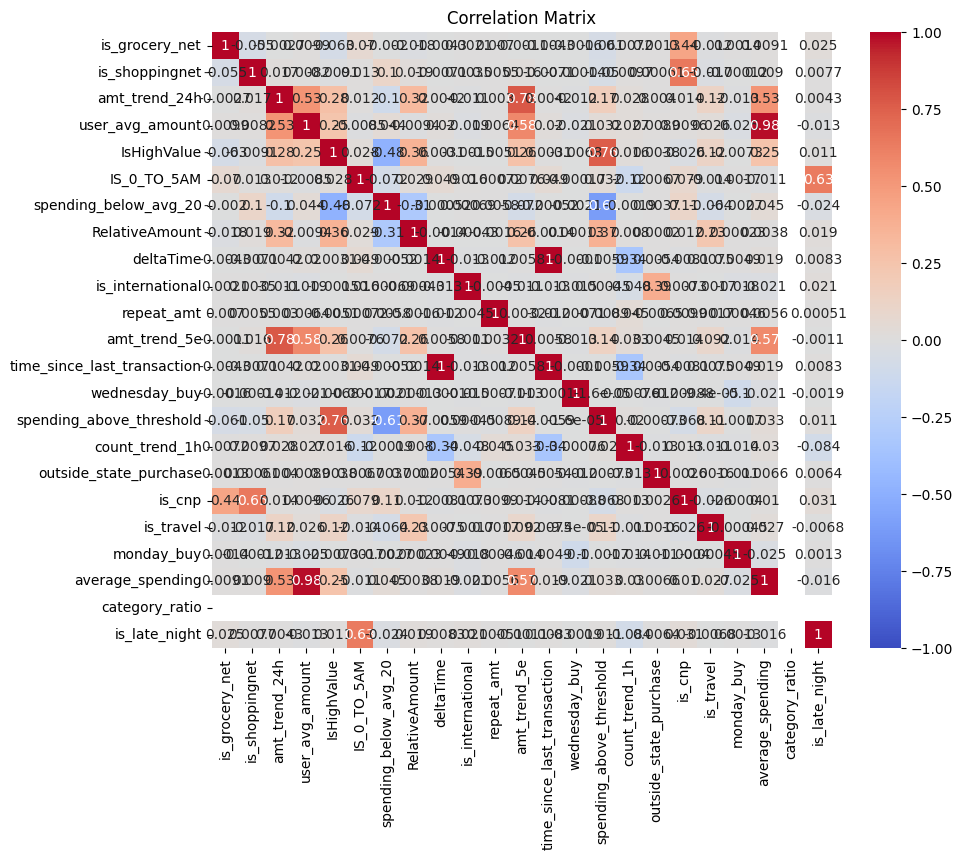

In [45]:
JF = df[features]
correlation_matrix = JF.corr(method='pearson')

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Matrix')
plt.show()

This plot shows how correlated our features are with other features in our dataframe. Higher numbers mean higher correlation. The diagonal of our correlation matrix is filled with ones since a feature is exactly correlated with itself by definition. When some variables are too correlated with each other, we usually remove the less impactful feature. Here, you can see that our IS_0_TO_5AM and is_late_night variables are somewhat correlated.

## Now that we have a dataframe with some potentially useful features, let's save it to be used in future sessions.

In [46]:
df['amount_diff'] = #TODO
df['num_last_24_hours'] = #TODO
df['num_hi_amt_last_hour'] = #TODO
df['category_ratio'] = #TODO

##Generate 3 other variables to be used in your neural net and logreg models

SyntaxError: invalid syntax (<ipython-input-46-2b502fe4eed8>, line 1)

In [49]:
df[df['is_train'] == 1].to_csv(f'/content/drive/MyDrive/FICO Analytic Challenge/Data/train_features.csv',index=False)
df[df['is_train'] == 0].to_csv(f'/content/drive/MyDrive/FICO Analytic Challenge/Data/test_A_features.csv',index=False)